# Explore your first RO-Crate

 An example how to explore a RO-Crate and how visualize its graph

### Packages, Parameters and Functions

In [2]:
from rocrate.rocrate import ROCrate
from rocrate.model.person import Person
from rocrate.model.contextentity import ContextEntity
import json

In [3]:
path="."
ro_crate_name="exercise_ro_crate"
crate_dir=path+"/"+ro_crate_name

In [4]:
def find_entities_by_type(crate, types):
    results = []
    if not isinstance(types, list):
        types = [types]
    
    for entity in crate.get_entities():
        entity_types = entity.type
        if not isinstance(entity_types, list):
            entity_types = [entity_types]
        
        if any(t in entity_types for t in types):
            results.append(entity)
            
    return results

### Charge the crate

In [5]:
try:
    crate = ROCrate(crate_dir)
    print(f"**Crate charged from directory: {crate_dir}")
except Exception as e:
    print(f" Error: {e}")
    exit()

**Crate caricato con successo** dalla directory: ./exercise_ro_crate


### Knowledge graph exploration

In [7]:
grouped_entities = {}


for entity in crate.get_entities():
    #get the type for each entity, if not it skips
    entity_types = entity.type
    
    if not entity_types:
        continue  
    
    # transform in list if it is not a list
    if not isinstance(entity_types, list):
        entity_types = [entity_types]

    # group by entity type, entity_type become the keys of the dictionary
    for entity_type in entity_types:
        if entity_type not in grouped_entities:
            grouped_entities[entity_type] = []
            
        #metadata extraction, this command create a copy of the dict associated to the entity 
        metadata = entity._jsonld.copy()
        
        metadata.pop('@id', None)
        metadata.pop('@type', None)
        
        
        grouped_entities[entity_type].append({
            "id": entity.id,
            "metadata_fields": list(metadata.keys()), #the  names
            "full_metadata": metadata # all the metadata
        })

### Print the results

In [8]:
all_types = list(grouped_entities.keys())
all_types.sort()

print(f"\n✨ **Semantic Type found (Total: {len(all_types)}):**")
print(", ".join(all_types))


✨ **Semantic Type found (Total: 5):**
CreativeWork, Dataset, File, Person, institute


### Detailed print

In [9]:
for entity_type in all_types:
    entities_list = grouped_entities[entity_type]
    print(f"\n=========================================================================")
    print(f" Type: **{entity_type}** (#Entities: {len(entities_list)})")
    print("=========================================================================")
    
    for i, entity_data in enumerate(entities_list, 1):
        print(f"  [{i}] ID: **{entity_data['id']}**")
        
        # Metadati presenti (chiavi)
        fields = entity_data['metadata_fields']
        print(f"      - Metadata fields ({len(fields)}): {', '.join(fields)}")
        
        
        print("      - Metadata Details :\n")
        print(json.dumps(entity_data['full_metadata'], indent=8, ensure_ascii=False))




 Type: **CreativeWork** (#Entities: 1)
  [1] ID: **ro-crate-metadata.json**
      - Metadata fields (2): conformsTo, about
      - Metadata Details :

{
        "conformsTo": {
                "@id": "https://w3id.org/ro/crate/1.1"
        },
        "about": {
                "@id": "./"
        }
}

 Type: **Dataset** (#Entities: 2)
  [1] ID: **./**
      - Metadata fields (5): datePublished, description, mainEntity, name, hasPart
      - Metadata Details :

{
        "datePublished": "2025-11-12T18:43:24+00:00",
        "description": "RO_Crate first exercise",
        "mainEntity": {
                "@id": "load_script.py"
        },
        "name": "Ex1_RO_Crate",
        "hasPart": [
                {
                        "@id": "nffa_instruments.csv"
                },
                {
                        "@id": "load_script.py"
                },
                {
                        "@id": "CNR_ISM/"
                }
        ]
}
  [2] ID: **CNR_ISM/**
      - Met

### Knowledge graph

In [10]:
import networkx as nx
import matplotlib.pyplot as plt


### Initialize

In [11]:
G = nx.DiGraph() 

node_types = {}
type_colors = {
    "Dataset": "skyblue",
    "File": "lightgreen",
    "SoftwareSourceCode": "yellow",
    "Person": "lightcoral",
    "License": "gold",
    "CreativeWork": "grey",
    "default": "silver"
}

### Add the nodes

In [12]:
for entity in crate.get_entities():
    # Estrae il tipo principale per la colorazione
    entity_type = entity.type
    if isinstance(entity_type, list):
        entity_type = entity_type[0]
    
    node_color = type_colors.get(entity_type, type_colors["default"])
    
    # Crea un'etichetta leggibile per il nodo (ID + Tipo)
    label = f"{entity.id}\n({entity_type})"
    
    # Aggiunge il nodo al Grafo
    G.add_node(entity.id, type=entity_type, label=label, color=node_color)
    node_types[entity.id] = node_color

### Add the edges

In [13]:
for entity in crate.get_entities():
    entity_jsonld = entity._jsonld
    source_id = entity.id

    # Iterate to find all the relations
    for prop, value in entity_jsonld.items():
        if prop.startswith('@'):
            continue  # skip fields like @id, @type, @context

        
        values = value if isinstance(value, list) else [value]
        
        for val in values:
            #relation is defined if value is an object with field @id
            
            if isinstance(val, dict) and '@id' in val:
                target_id = val['@id']
                
                # add the edge
                # label=property (es. 'author', 'hasPart') 
                if G.has_node(source_id) and G.has_node(target_id):
                    G.add_edge(source_id, target_id, relation=prop)

### Setup to draw the graph

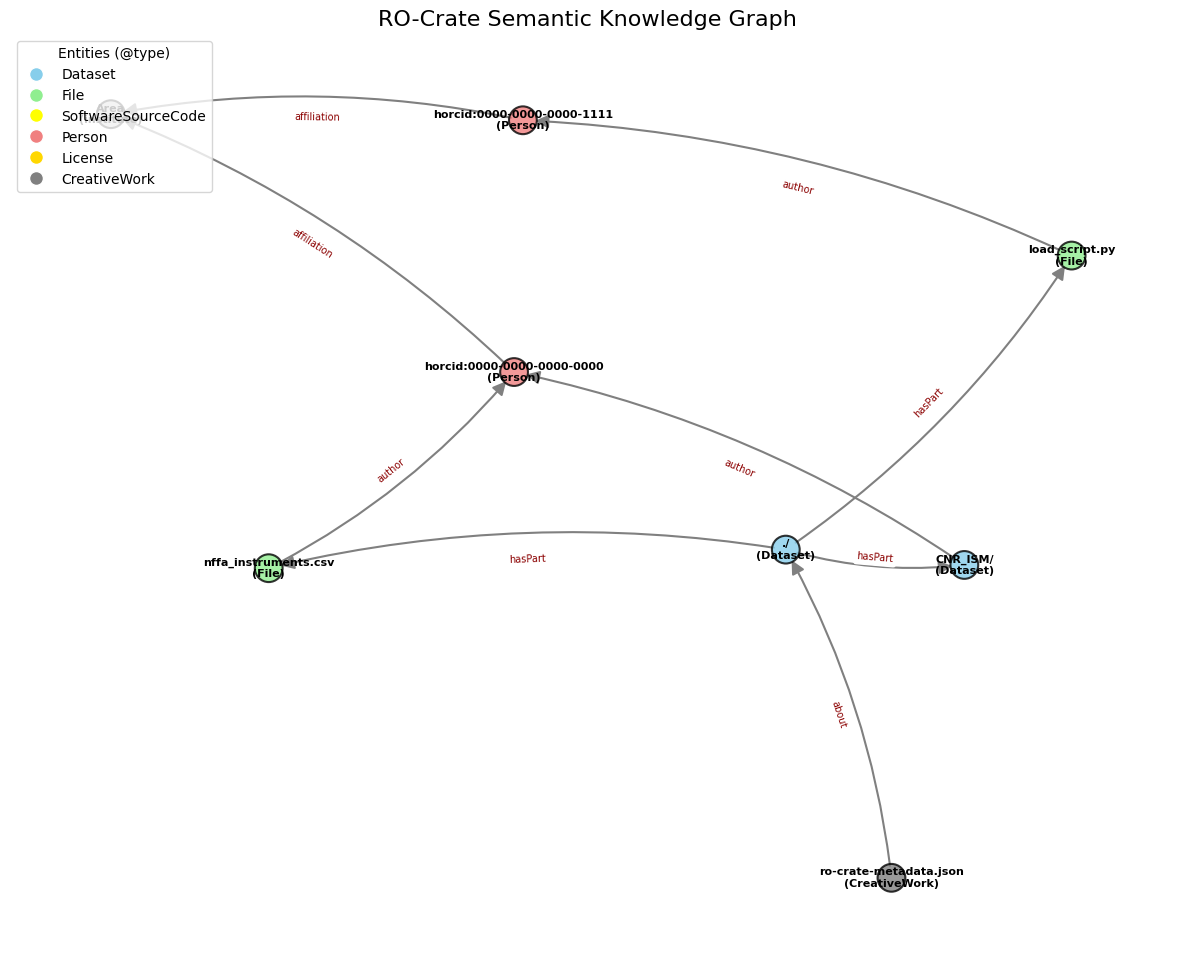

In [16]:

plt.figure(figsize=(15, 12))

#Layout
pos = nx.spring_layout(G, k=0.3, iterations=50)

#get colors and lables
node_colors = [node_types.get(node, type_colors["default"]) for node in G.nodes()]
node_labels = {node: G.nodes[node]['label'] for node in G.nodes()}

# draw nodes
nx.draw_networkx_nodes(
    G, pos, 
    node_color=node_colors, 
    node_size=400, 
    alpha=0.8,
    edgecolors='black',
    linewidths=1.5
)

# draw labels
nx.draw_networkx_labels(
    G, pos, 
    labels=node_labels, 
    font_size=8, 
    font_weight='bold', 
    verticalalignment='center'
)
# draw edges
nx.draw_networkx_edges(
    G, pos, 
    edge_color='gray', 
    arrowsize=20, 
    width=1.5,
    connectionstyle="arc3,rad=0.1" # Leggera curvatura per archi bidirezionali
)

# 7draw edges labels
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(
    G, pos, 
    edge_labels=edge_labels, 
    font_size=7, 
    font_color='darkred'
)

#legen and title
legend_patches = []
for entity_type, color in type_colors.items():
    if entity_type != "default":
        from matplotlib.lines import Line2D
        legend_patches.append(Line2D([0], [0], marker='o', color='w', label=entity_type, 
                                     markerfacecolor=color, markersize=10))

plt.legend(handles=legend_patches, title="Entities (@type)", loc='upper left')
plt.title("RO-Crate Semantic Knowledge Graph ", fontsize=16)
plt.axis('off') 
plt.show()